<a href="https://colab.research.google.com/github/fmuranda/Remote-Sensing/blob/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/W1D2_Tutorial3.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W1D2_Ocean-AtmosphereReanalysis/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Atmospheric  Circulation

**Week 1, Day 2, Ocean-Atmosphere Reanalysis**

**Content creators:** Momme Hell

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Paul Heubel, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Paul Heubel, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

**Our 2024 Sponsors:** CMIP, NFDI4Earth


# Tutorial Objectives

*Estimated timing of tutorial:* 30-40 mins

In the previous tutorial, you examined atmospheric surface temperatures. Spatial variations in surface temperature created by uneven solar radiation (e.g., between the equator and poles), are one of the main drivers of global-scale air movement. Other processes such as the Earth's rotation, storm tracks, and surface topography can also influence global wind patterns.

By the end of this tutorial, you will be able to:

- Describe the seasonal variations in surface winds.
- Calculate seasonal climatologies and create global maps.
- Compare statistics derived from these climatologies.

In this tutorial, you will again utilize the monthly mean surface wind fields from ERA5 over a 30-year period.

# Setup

In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 92.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pooch
import tempfile
import numpy as np
import xarray as xr
import warnings
from cartopy import crs as ccrs, feature as cfeature

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings("ignore")

In [3]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W1D2_T3"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


In [4]:
# @title Plotting Functions


def set_projection_figure(projection=ccrs.PlateCarree(), figsize=plt.rcParams['figure.figsize']):
    # source:https://foundations.projectpythia.org/core/cartopy/cartopy.html
    # edit by PH: figsize defined by cma.mplstyle in Figure Settings section

    projLccNY = projection  # ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=projLccNY)

    format_axes(ax)
    # ax.add_feature(cfeature.STATES)
    # ax.add_feature(cfeature.RIVERS)
    return fig, ax


def format_axes(ax):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor="black", facecolor="None", alpha=0.3)
    gl = ax.gridlines(
        draw_labels=True, linewidth=1, color="black", alpha=0.5, linestyle="--"
    )
    gl.xlocator = ticker.MaxNLocator(7)
    gl.ylocator = ticker.MaxNLocator(5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    # gl.xlines = False


# helping functions:
def geographic_lon_to_360(lon):
    return 360 + lon


def inverted_geographic_lon_to_360(lon):
    return lon - 180


def cbar_label(DD):
    return DD.attrs["long_name"] + " [" + DD.attrs["units"] + "]"

In [5]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W1D2_Ocean-AtmosphereReanalysis"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [6]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [7]:
# @title Video 1: The Wind Driven Circulation

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'zgwShu0xXYA'), ('Bilibili', 'BV1NN411U7Eb')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [8]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Wind_Driven_Circulation_Video")

In [9]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "t6c78"

print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/t6c78/


In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Wind_Driven_Circulation_Slides")

# Section 1: Surface Winds


The large-scale atmospheric circulation significantly influences the climate we experience at different latitudes. The global atmospheric circulation is often depicted as a three-cell structure, as visualized [in this figure showing the surface winds](https://commons.wikimedia.org/wiki/File:Earth_Global_Circulation_-_en.svg):

![Earth Global Circulation - en.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Earth_Global_Circulation_-_en.svg/740px-Earth_Global_Circulation_-_en.svg.png?20190829153037).


This schematic of atmospheric circulation cells reveal meridional (north-south) and zonal (east-west) components of the large-scale surface winds.

Let's see if you are able to detect these large-scale patterns in reanalysis data!
For this, you will load ERA5 wind data, which we pre-processed after retrieving it from the [Pangeo catalog](https://pangeo.io/catalog.html).


## Section 1.1: Annual Mean Wind Speed

You should start investigating this data by examining the global surface winds. These winds are represented as vectors, consisting of a zonal component denoted as `u10` and a meridional component denoted as `v10`.

Recall from the previous tutorial that the magnitude of the wind vector represents the wind speed you will use later in the tutorial, given by:

\begin{align}
||u|| = \sqrt{u^2 + v^2}
\end{align}

To examine long-term changes in the wind field you should visualize the zonal wind component $u$ and the meridional wind component $v$ with monthly mean data. With the help of `xarray`, you can derive monthly means from higher-resolution data (such as those used in tutorial 2) using the `xr.resample('1M').mean('time')` function.

For your convenience, we have already performed this step, and you can load the data using the following instructions:

- The variable `si10` represents the wind speed in this dataset.
- To calculate the long-term mean, we selected 30 years of data ranging from 1980 to 2010.

Let's grab the reanalysis data from before that we have preprocessed (noting naming convention changes):

In [11]:
# note this can take a few minutes to download
filename_era5_mm = "ERA5_surface_winds_mm.nc"
url_era5_mm = "https://osf.io/3q4vs/download"

ERA5_mm = xr.open_dataset(pooch_load(url_era5_mm, filename_era5_mm)).sel(
    time=slice("1980", "2006")
)  # select the timeslice during loading
ERA5_mm

SHA256 hash of downloaded file: 8899062c8e9ef24bcbf947e7c618aa7b4ada26b4e0fb5611d0a94850ac75f0d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 8GB
Dimensions:    (longitude: 1440, latitude: 721, time: 312)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2kB 1980-01-01 1980-02-01 ... 2005-12-01
Data variables:
    u10        (time, latitude, longitude) float64 3GB ...
    v10        (time, latitude, longitude) float64 3GB ...
    si10       (time, latitude, longitude) float64 3GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-06 23:25:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Now calculate the temporal mean of the surface wind speed.

In [12]:
# take the temporal mean over 26 years (Jan 1980 - Dec 2005)
ERA5_mean = ERA5_mm.mean("time")

In [13]:
ERA5_mean

<xarray.Dataset> Size: 25MB
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    u10        (latitude, longitude) float64 8MB -0.03086 -0.03086 ... 0.4983
    v10        (latitude, longitude) float64 8MB 0.004272 0.004272 ... 0.04225
    si10       (latitude, longitude) float64 8MB 5.919 5.919 5.919 ... 5.49 5.49

To visualize this data, we will be using some helper functions defined in the beginning of the tutorial just to set the map features and aesthetics. Please take a look at them if you are interested in seeing how they work.

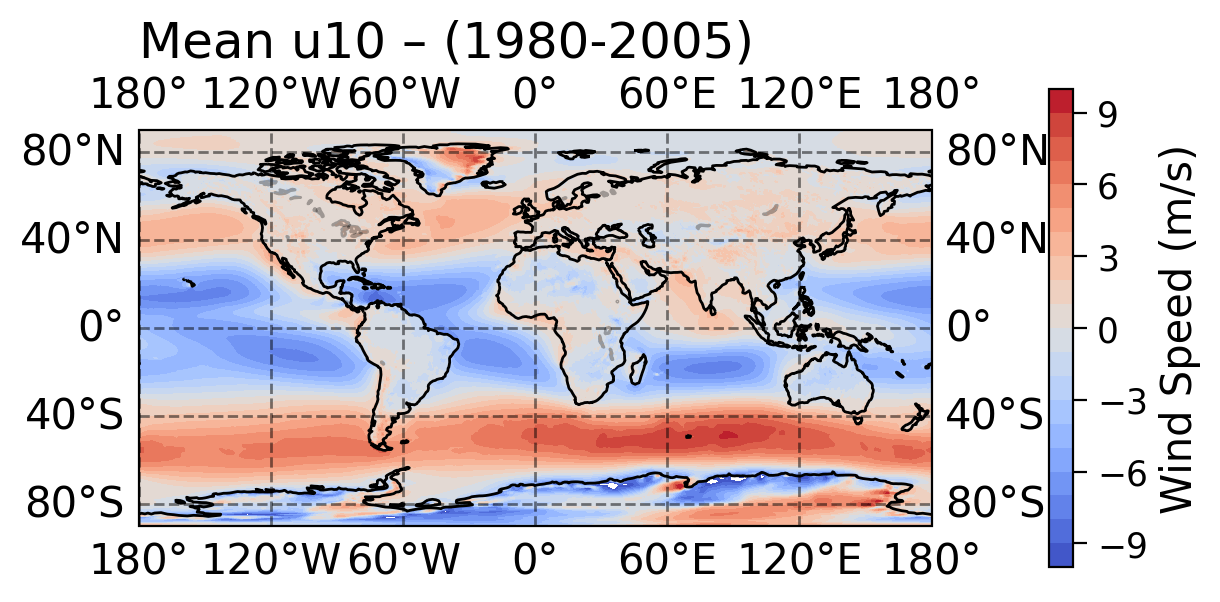

In [14]:
# adjust color levels to weaker amplitudes
colorlevels_clim = np.arange(-10, 11, 1)

var = "u10"  # select our variable
fig, ax = set_projection_figure(
    projection=ccrs.PlateCarree()
)  # same plot function as Part I
ax.set_title("Mean " + var + " – (1980-2005)", loc="left")
dataplot = ax.contourf(
    ERA5_mean.longitude,
    ERA5_mean.latitude,
    ERA5_mean[var],
    levels=colorlevels_clim,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.coolwarm,
)
fig.colorbar(dataplot, orientation="vertical", label="Wind Speed (m/s)",
             shrink=0.55, pad=0.11
            )

<details>
<summary><font color='orangered'>Click here for a description of the plot  </font></summary>
In the zonal wind speed figure you created, two distinct wind bands between 35° to 65° both north and south of the equator blow from west to east (red, positive wind speeds). These mid-latitude wind bands are known as the <b>westerlies</b>. Additionally, you can see that winds predominantly blow from the east to the west (blue, negative wind speeds) in the tropics (less than 30° N/S), and are referred to as the <b>easterlies</b>.

***

</details>

### Coding Exercise 1.1: Mean Meridional Wind
Reproduce the previous figure, but modify it to plot the **meridional wind**  rather than  the **zonal wind** component.

In [ ]:
#################################################
## TODO for students: add the variable of interest to be plotted. ##
# Remove the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Add the variable of interest to be plotted.")
#################################################
var = ...
fig, ax = set_projection_figure(projection=ccrs.PlateCarree())
ax.set_title("Mean " + str(var) + " – (1980-2005)", loc="left")
dataplot = ax.contourf(
    ERA5_mean.longitude,
    ERA5_mean.latitude,
    ERA5_mean[var],
    levels=colorlevels_clim,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.coolwarm,
)
fig.colorbar(dataplot, orientation="vertical", label="Wind Speed (m/s)", shrink=0.55, pad=0.11)

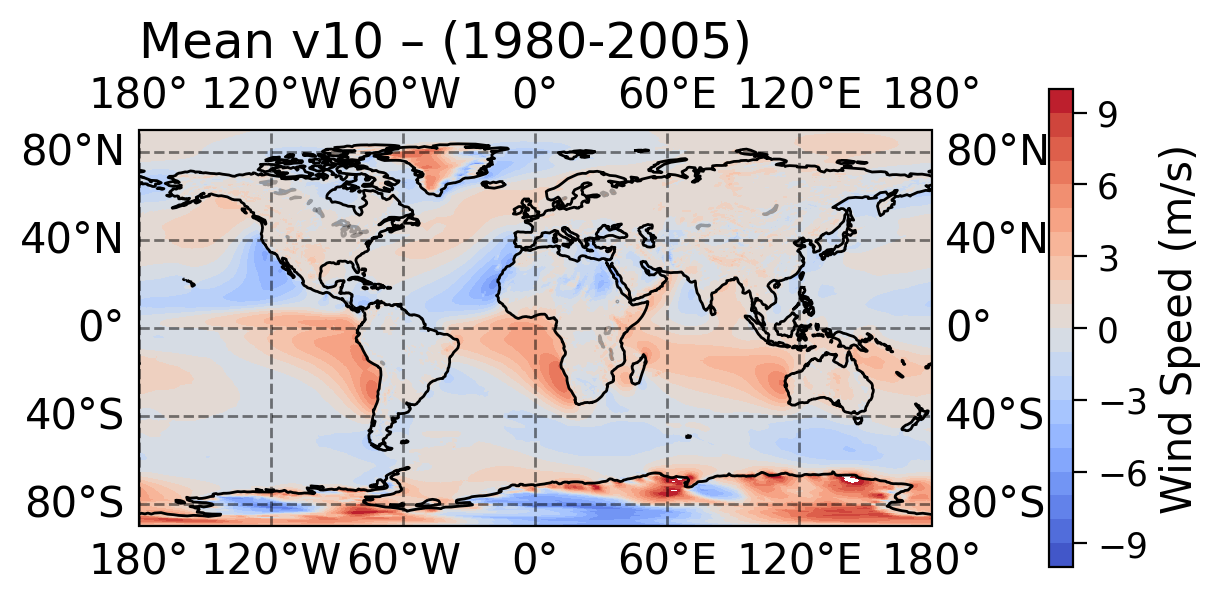

In [17]:
# to_remove solution
var = "v10"
fig, ax = set_projection_figure(projection=ccrs.PlateCarree())
ax.set_title("Mean " + str(var) + " – (1980-2005)", loc="left")
dataplot = ax.contourf(
    ERA5_mean.longitude,
    ERA5_mean.latitude,
    ERA5_mean[var],
    levels=colorlevels_clim,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.coolwarm,
)
fig.colorbar(dataplot, orientation="vertical", label="Wind Speed (m/s)", shrink=0.55, pad=0.11)

<details>
<summary><font color='orangered'>Click here for a description of the plot  </font></summary>
There are strong southward winds in the subtropics of the Northern Hemisphere (blue, negative wind speed), and northward winds in the subtropics of the Southern Hemisphere (red, positive wind speed). The meridional winds are strongest on the western side of the continents.

***

</details>

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercise_1_1")

### Questions 1.1
1. Among the three atmospheric "cells" (the Hadley Cell, Ferrel Cell, and Polar Cell) depicted in the figure from Section 1 above, which ones correspond to the zonal wind bands that we visualized in the first plot above?
2. How do the zonal and meridional winds compare in magnitude, longitude, and latitude?

In [18]:
# to_remove explanation
'''
1. The Hadley Cell is the tropical region containing the easterlies (a.k.a. trade winds), and the Ferrel Cell is the mid-latitude region containing the westerlies.
2. Meridional winds are typically weaker and less variable than zonal winds. This is due to the general circulation of the atmosphere, which primarily moves air in the east-west direction rather than north-south.
'''

'\n1. The Hadley Cell is the tropical region containing the easterlies (a.k.a. trade winds), and the Ferrel Cell is the mid-latitude region containing the westerlies.\n2. Meridional winds are typically weaker and less variable than zonal winds. This is due to the general circulation of the atmosphere, which primarily moves air in the east-west direction rather than north-south.\n'

In [19]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_1_1")

## Section 1.2: Zonal-mean Wind Speed

To examine the latitudinal variation in the surface winds, you can plot the zonal mean of the annual mean zonal and meridional winds:


Text(30, 20, 'S')

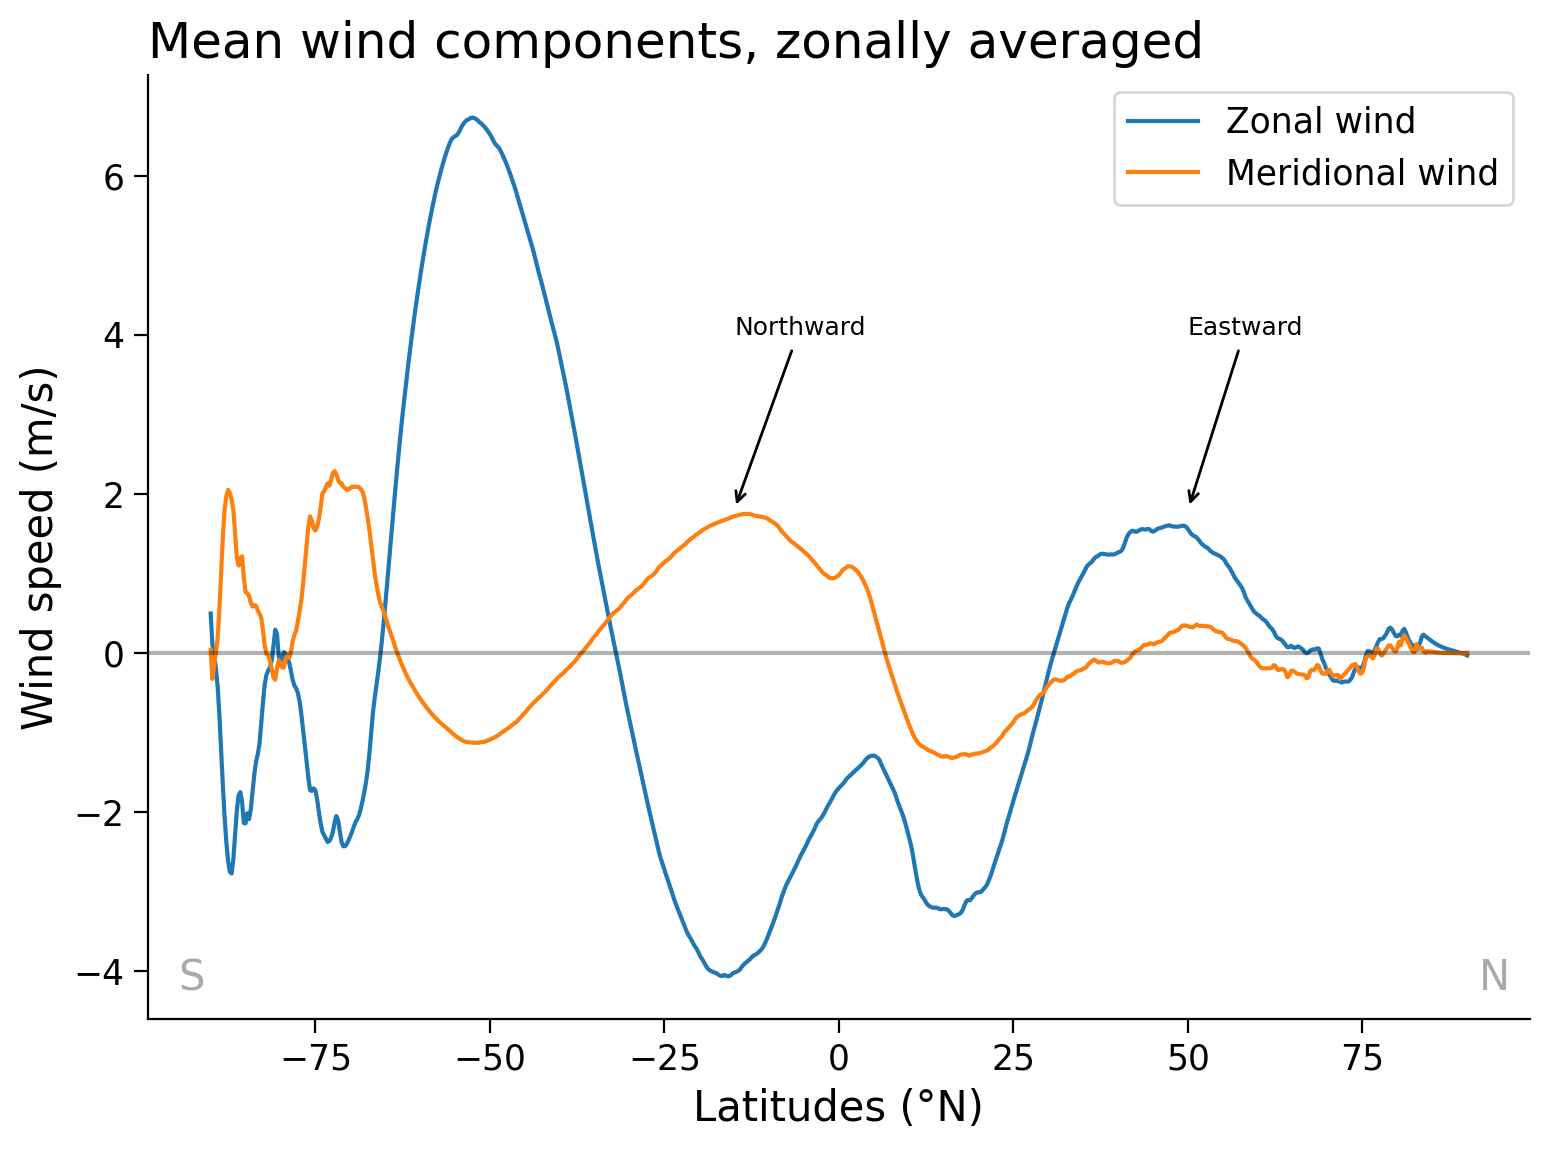

In [20]:
fig, ax = plt.subplots()

# calculate zonal mean over all longitudes
ERA5_mean_zmean = ERA5_mean.mean("longitude")

# select the u10 & v10 variable and plot it
ERA5_mean_zmean["u10"].plot( label="Zonal wind", ax = ax )
ERA5_mean_zmean["v10"].plot( label="Meridional wind", ax = ax )

# aesthetics
ax.legend()  # add legend
ax.set_title("Mean wind components, zonally averaged", loc="left")  # add title
ax.set_xlabel("Latitudes (°N)") # axis labels
ax.set_ylabel("Wind speed (m/s)")
ax.axhline(0, color="black", alpha=0.3)  # add a black line at x = 0
#ax.grid(True)

# Add annotations to the plot for improved readability
# arrow & annot. to emphasize wind direction of meridional wind (positive speed)
ax.annotate("Northward", xy=(-15, 1.8),  xytext= (-15, 4), xycoords='data', size=9,
            arrowprops=dict(arrowstyle="->"))
# arrow & annot. to emphasize wind direction of zonal wind (positive speed)
ax.annotate("Eastward", xy=(50, 1.8),  xytext= (50, 4), xycoords='data', fontsize=9,
            arrowprops=dict(arrowstyle="->"))
# annotate N hemisphere/ pole
ax.annotate('N', xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom', color='darkgray')
# annotate S hemisphere/ pole
ax.annotate('S', xy=(0, 0), xycoords='axes fraction',
            xytext=(30, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom', color='darkgray')

### Questions 1.2
1. Considering the zonal-mean wind speed figure provided, what factors contribute to the noticeable disparities between the Northern and Southern Hemispheres in terms of wind patterns?

In [21]:
# to_remove explanation

"""
1. The continents influence the strength of the winds, and since the continents are so unevenly distributed on the planet, the winds are weaker in the North than in the South. The strongest winds occur in the Southern Ocean, where there is little land, and must become very strong to create the same drag as over the large land masses of the Northern Hemisphere.
"""

'\n1. The continents influence the strength of the winds, and since the continents are so unevenly distributed on the planet, the winds are weaker in the North than in the South. The strongest winds occur in the Southern Ocean, where there is little land, and must become very strong to create the same drag as over the large land masses of the Northern Hemisphere.\n'

In [22]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_1_2")

# Section 2: Monthly Climatology

Now, you should examine how the zonal mean winds vary throughout the seasons. You will focus on the zonal wind component and create a special type of diagram called a Hovmöller diagram. In this diagram, the horizontal axis represents latitude, while the vertical axis represents time.

By using the [Hovmöller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram), you can visualize how the average east-west winds change over the annual cycle.

At first, we average our original dataset over all longitudes to get the zonal mean of all variables. We then temporally average it with respect to all months, resulting in a data set with twelve time steps which represent the mean of every month over the whole period of January 1980 to December 2005 for all three variables (`u10`, `v10` and `si10`).

In [23]:
# Note how we use several commands in one line.
# Python performs them in order. First, calculate the zonal mean, then group by month, and lastly calculate the mean.
# The groupby method hereby regroups the data by month, such that all Januarys, all Februaries, .. can be averaged.

ERA5_zmean_mmean = ERA5_mm.mean("longitude").groupby("time.month").mean()

In [24]:
# Have a look at our new dataset, which incorporates the zonal mean and the temporal mean of every month
ERA5_zmean_mmean

<xarray.Dataset> Size: 211kB
Dimensions:   (month: 12, latitude: 721)
Coordinates:
  * latitude  (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u10       (month, latitude) float64 69kB -0.05 -0.04912 ... 0.09748 0.3667
    v10       (month, latitude) float64 69kB -0.008102 -0.001439 ... 0.05564
    si10      (month, latitude) float64 69kB 6.438 6.43 6.444 ... 4.537 4.484

We plot the zonal wind component `u10` of the wind vector versus month and latitude, i.e. the aforementioned Hovmöller diagram, which is a special type of [heatmap](https://en.wikipedia.org/wiki/Heat_map) and might remind you of the [Warming Stripes](https://en.wikipedia.org/wiki/Warming_stripes).

It allows us to recognize both spatial (abscissa/ x-axis) and temporal changes (ordinate/ y-axis) in our variables.

Note that xarray uses the metadata of the dataset to label the axes, hence it does not look as pretty and insightful as our previous plots. If you have difficulties to interpret the output, perhaps it helps to look at the previous blue line plot, to compare the axes and to try to understand how the shown extrema translate into colors of the Hovmöller diagram.

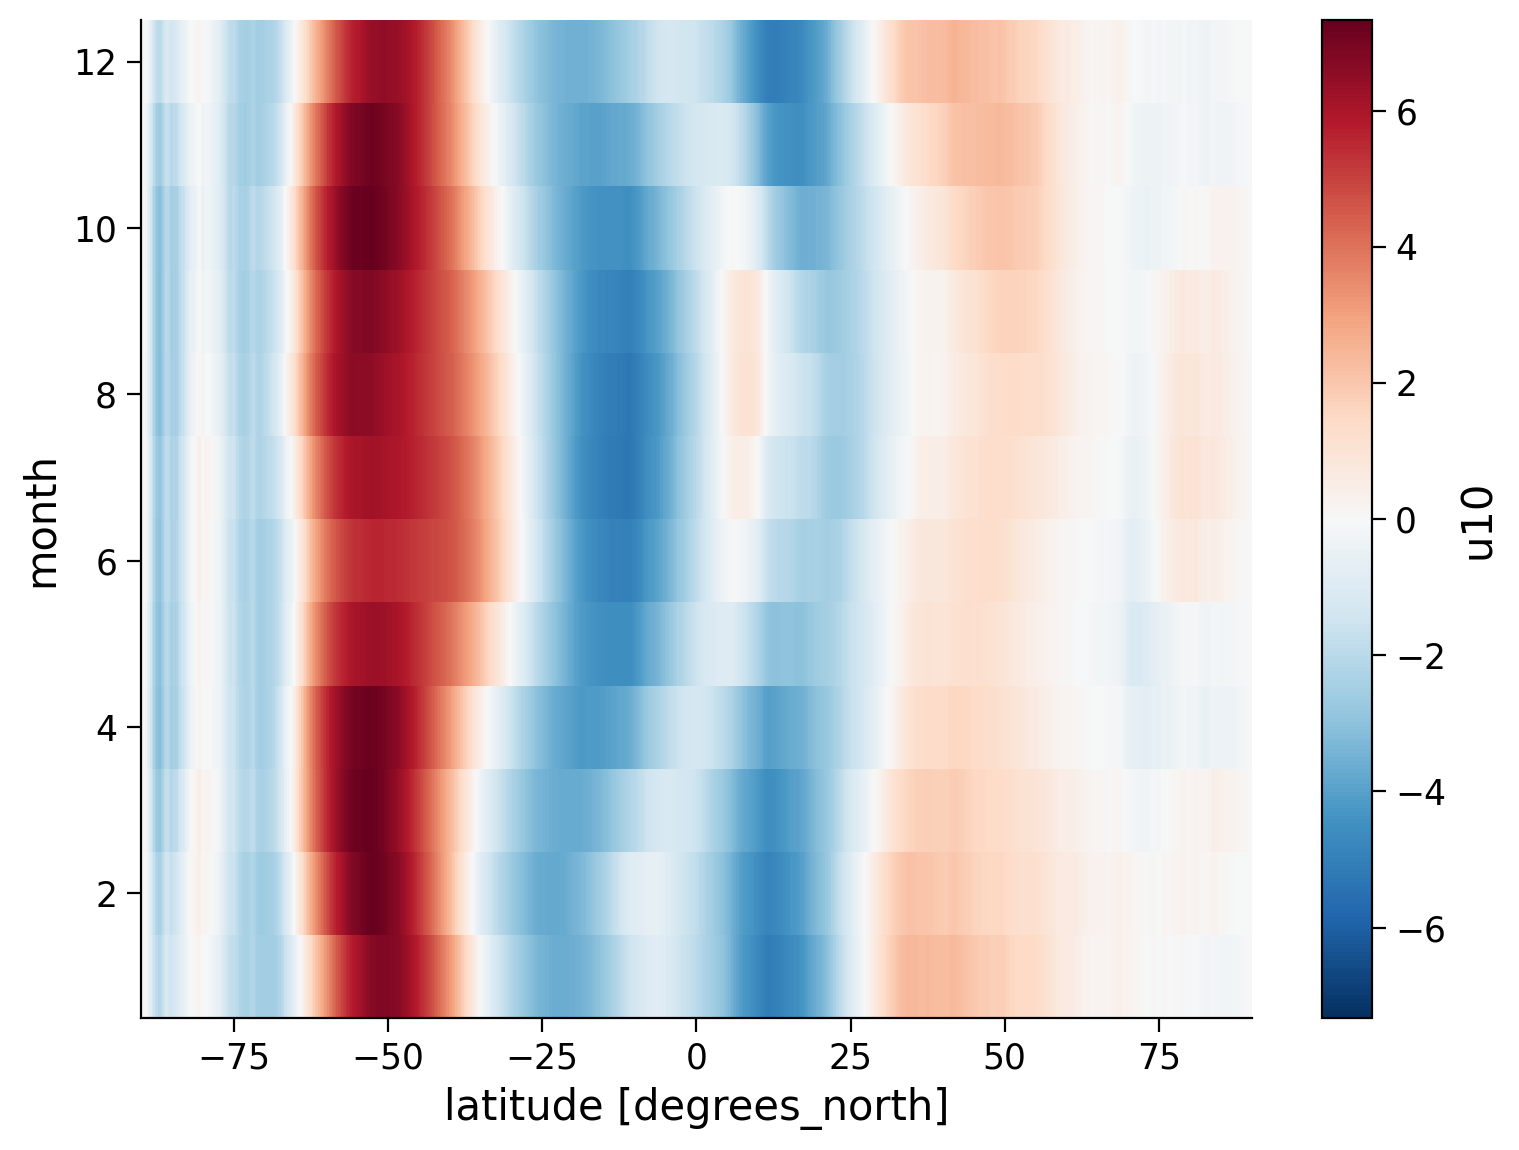

In [25]:
# plot the zonal wind component of the wind vector
_ = ERA5_zmean_mmean.u10.plot()

<details>
<summary><font color='orangered'>Click here for a description of the plot  </font></summary>
This Hovmöller diagram shows the zonal wind vector component $u$ for every month and latitude (in °N) after being averaged over 26 years (1980 - 2005) and all longitudes. The wind bands are almost symmetrical in width with regard to the hemispheres, but not in magnitude. The zonal wind is way stronger in the Southern Hemisphere (negative latitude range). Over time the east-west and vice versa winds shift to the north in boreal summer (i.e. summer in the Northern Hemisphere). Furthermore, wind bands of westerly winds arise around the equator and the northern high latitudes in boreal summer, while less changes in the southern high latitudes. The easterlies (negative wind speed) around the equator seasonally oscillate in magnitude. In other words, in the respective summer of the hemisphere winds weaken, while they increase in winter.

***

</details>

### Coding Exercises 2

Extend the above analysis to create a Hovmöller diagram of the meridional winds.

In [26]:
# select the variable of interest and plot it with xarray's plotting method
_ = ...

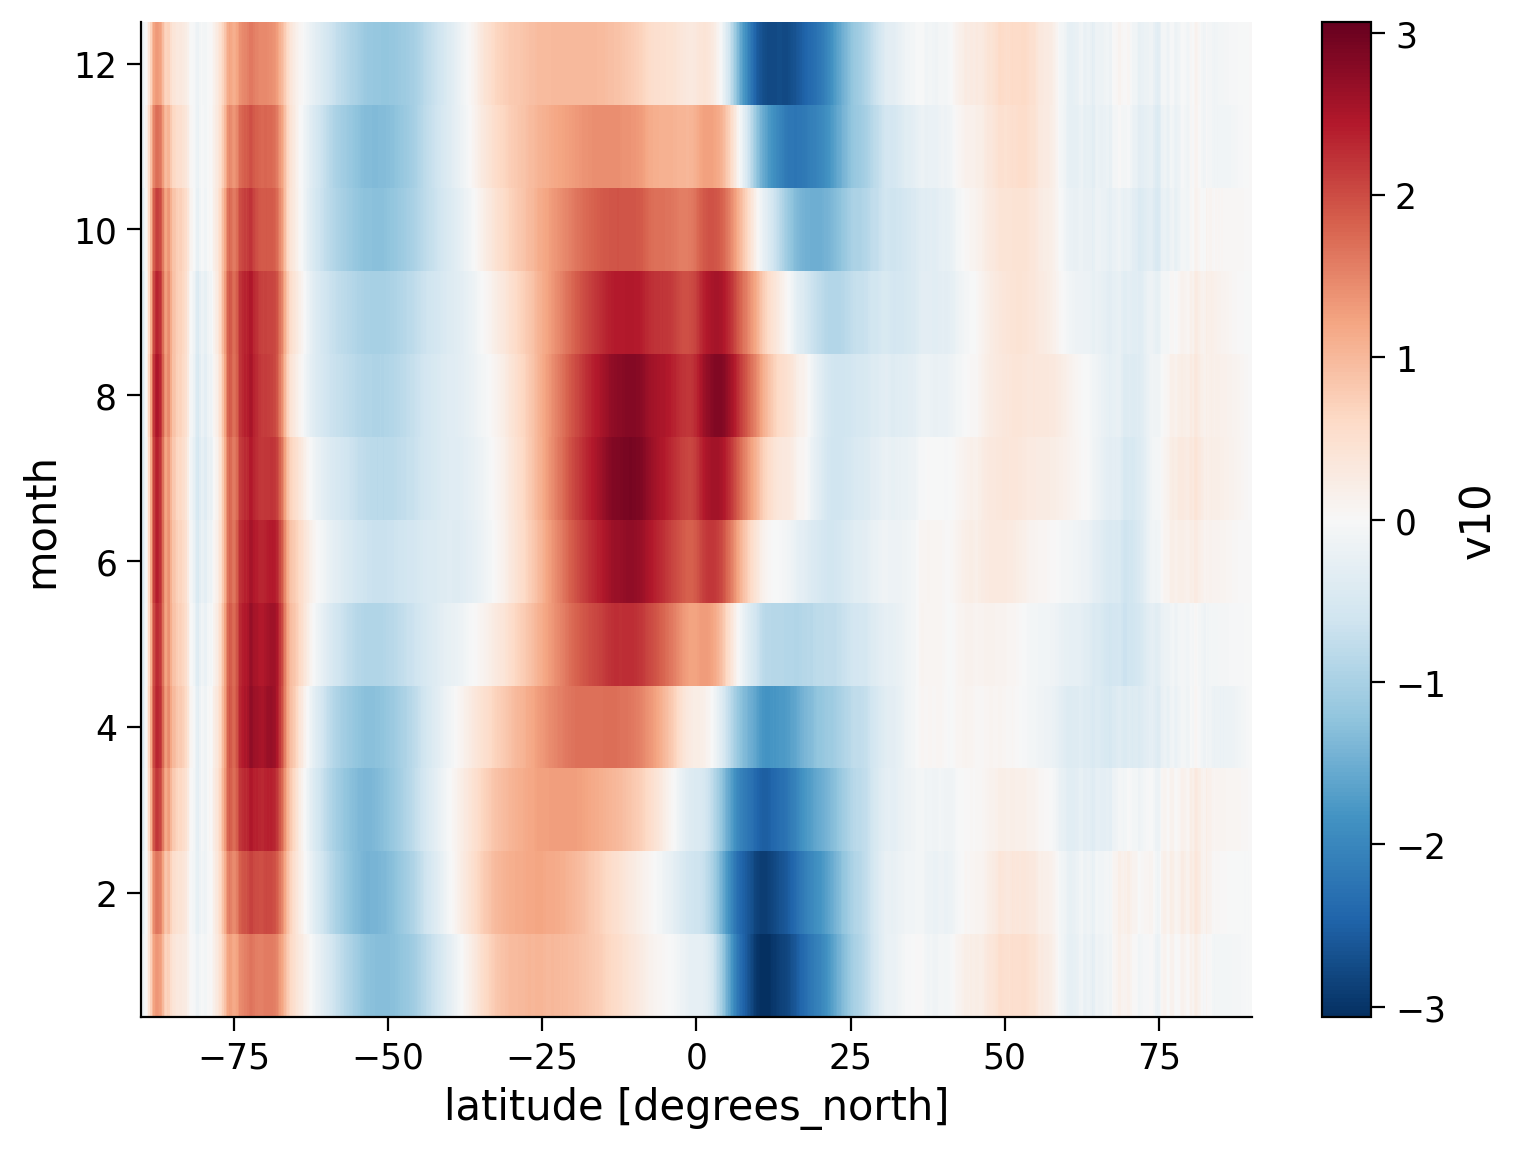

In [27]:
# to_remove solution

# select the variable of interest and plot it with xarray's plotting method
_ = ERA5_zmean_mmean.v10.plot()

<details>
<summary><font color='orangered'>Click here for a description of the plot  </font></summary>
This Hovmöller diagram shows the meridional wind vector component $v$ for every month and latitude (in °N) after being averaged over 26 years (1980 - 2005) and all longitudes. The meridional wind is way stronger in the Southern Hemisphere (negative latitude range). Over time the north-south and vice versa wind bands that blow towards the equator shift to the north in boreal summer (i.e. summer in the Northern Hemisphere). There are strong winds in northern direction but less changes in the southern high latitudes. The south winds (blue, negative wind speed) and north winds (red, positive wind speed) around the equator seasonally oscillate in magnitude. In other words, in the respective summer of the hemisphere, meridional winds weaken, while they increase in winter.

***

</details>

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercises_2")

*In summary:*
- The winds in the Southern Hemisphere appear to be generally stronger compared to the Northern Hemisphere.
- The period between June and September shows strong meridional winds. These winds result from the seasonal variation of the Hadley cell. During the winter in each respective hemisphere, the Hadley cell becomes much stronger, leading to the intensification of meridional winds.

# Bonus Section 3: Seasonal differences of the zonal wind

The solar insulation leads to varying circulation patterns within the seasons. To explore this seasonality you can proceed as follows:

- Plot the global map for the seasons December to February (DJF) and June to August (JJA) of the zonal wind. What do you see when you compare the mid-latitudes? (You can also plot their difference!)

- Plot the trend of the zonally averaged zonal wind vector component in DJF.

You can find out more in [Global Physical Climatology](https://www.atmos.washington.edu/~dennis/gpc.html),
[The Atmospheric General Circulation](https://www.cambridge.org/us/academic/subjects/earth-and-environmental-science/atmospheric-science-and-meteorology/atmospheric-general-circulation?format=HB&isbn=9781108474245)
or the first few chapters of this evolving draft [Physics of Earth's Climate](https://climate-dynamics.org/wp-content/uploads/2017/04/Climate_Book.pdf)


In [ ]:
# select the variable of interest, group the data by season, and average over all seasons.
# note, this code takes a while to run,
# to test your solution and to reduce the duration select a smaller period
ERA5_season_u10 = ...

In [ ]:
# to_remove solution
# select the variable of interest, group the data by season, and average over all seasons.
# note, this code takes a while to run,
# to test your solution and to reduce the duration select a smaller period
ERA5_season_u10 = ERA5_mm.u10.sel(time=slice('2000','2005')).groupby('time.season').mean()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Bonus_Coding_Exercise_3_1")

In [ ]:
ERA5_season_u10

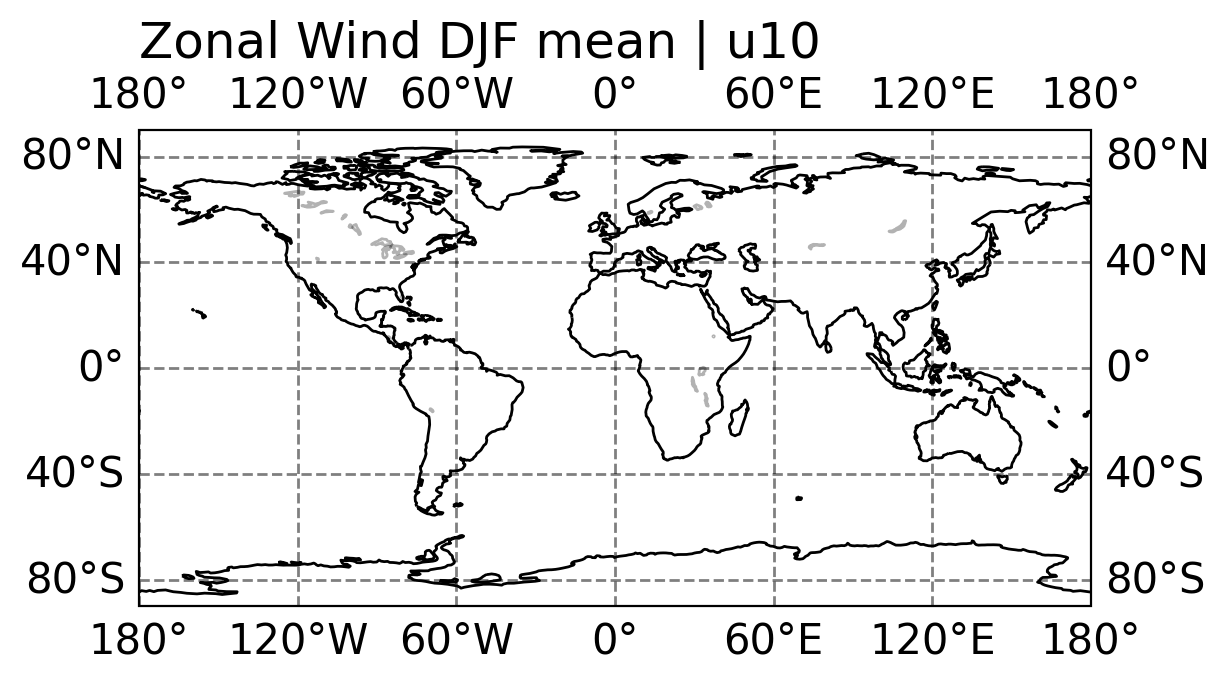

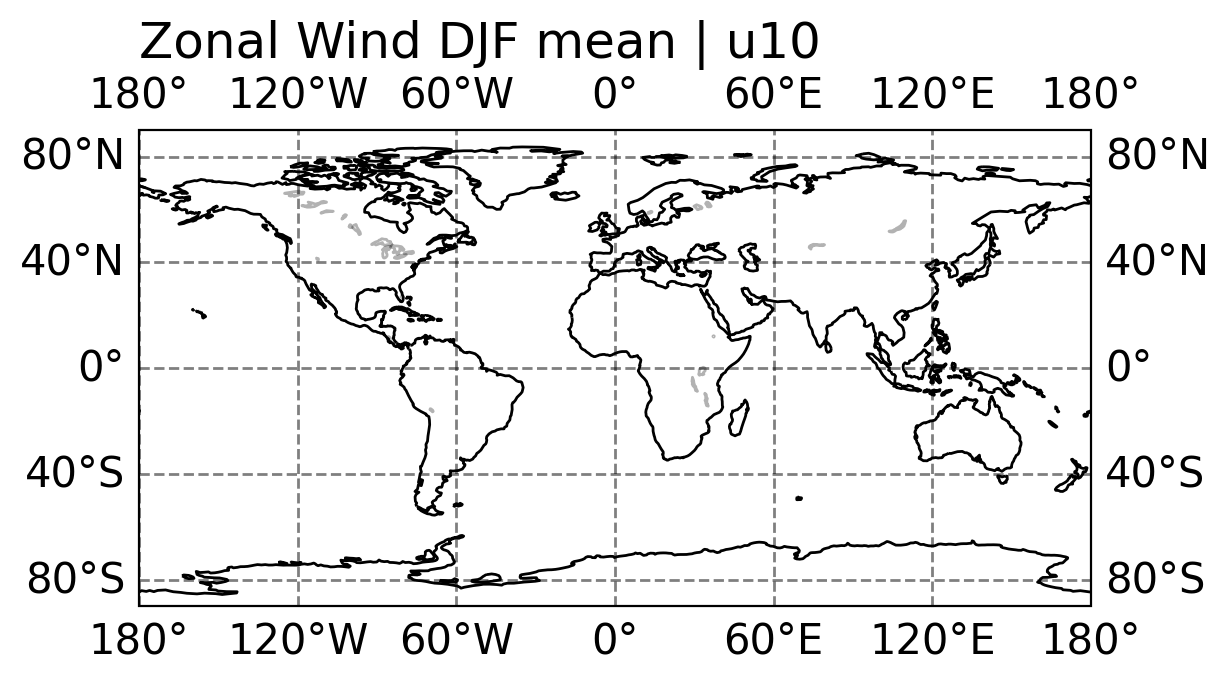

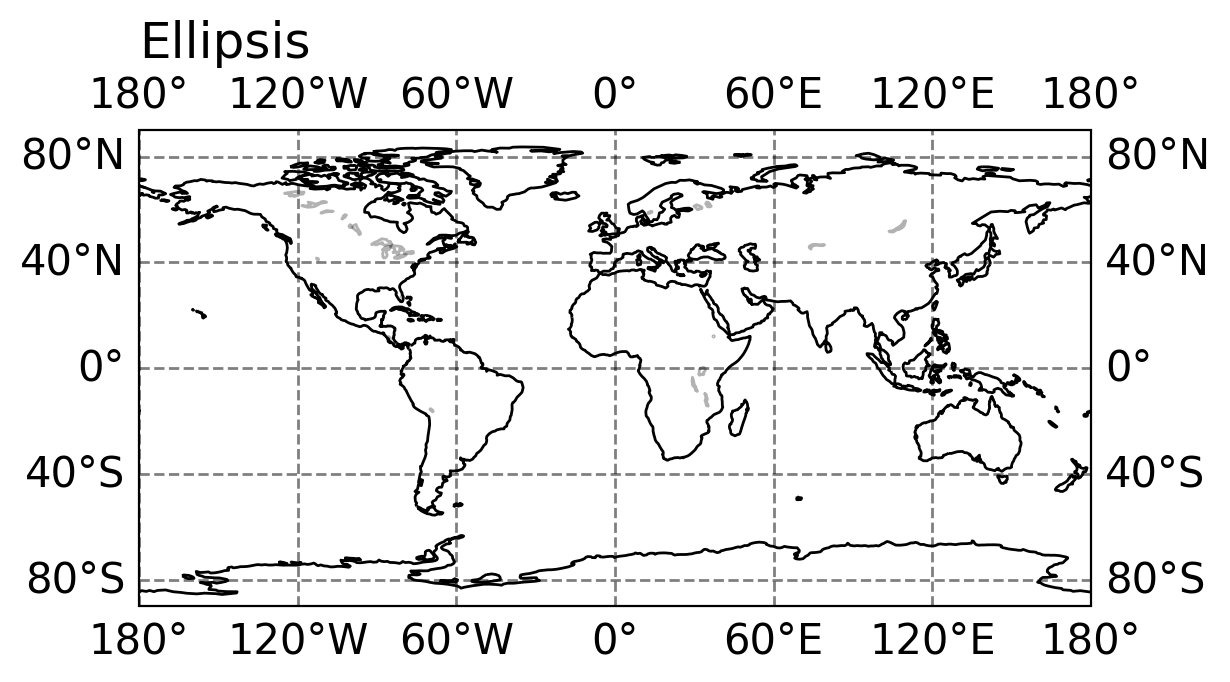

In [28]:
var='u10'
season='DJF'
F, ax = set_projection_figure(projection = ccrs.PlateCarree())
ax.set_title('Zonal Wind DJF mean | '+ var , loc ='left')
dataplot = ...
_ = ... # colorbar
plt.show()

season='JJA'
F, ax = set_projection_figure(projection = ccrs.PlateCarree())
ax.set_title('Zonal Wind DJF mean | '+ var , loc ='left')
dataplot = ...
_ = ... # colorbar
plt.show()

# difference:
pdata = ...

F, ax = set_projection_figure(projection = ccrs.PlateCarree())
ax.set_title(... , loc ='left')
dataplot = ...
_ = ... # colorbar
plt.show()

NameError: name 'ERA5_season_u10' is not defined

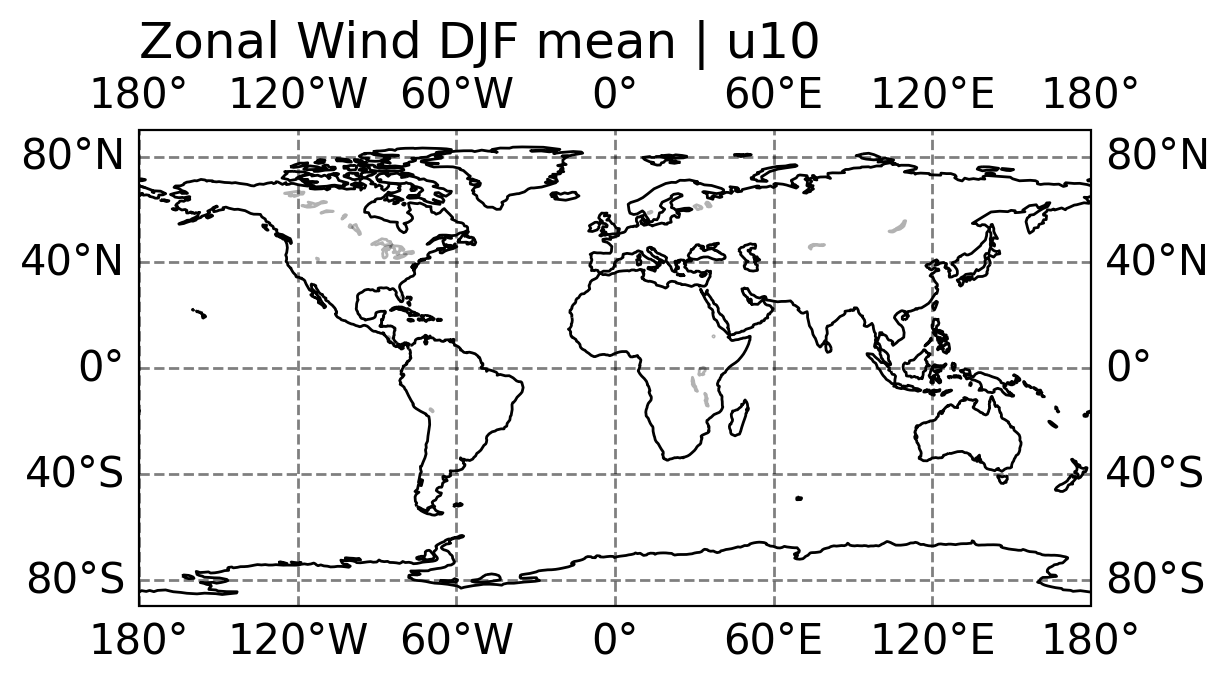

In [30]:
# to_remove solution
var='u10'
season='DJF'
F, ax = set_projection_figure(projection = ccrs.PlateCarree())
ax.set_title('Zonal Wind DJF mean | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season_u10.longitude, ERA5_season_u10.latitude, ERA5_season_u10.sel(season=season),
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
_ = plt.colorbar(dataplot, orientation='vertical', label = 'Wind speed (m/s)', shrink= 0.55 , pad = 0.11) # colorbar
plt.show()

season='JJA'
F, ax = set_projection_figure(projection = ccrs.PlateCarree())
ax.set_title('Zonal Wind DJF mean | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season_u10.longitude, ERA5_season_u10.latitude, ERA5_season_u10.sel(season=season),
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
_ = plt.colorbar(dataplot, orientation='vertical', label = 'Wind speed (m/s)', shrink= 0.55 , pad = 0.11) # colorbar
plt.show()

# difference:
pdata = ERA5_season_u10.sel(season='DJF') - ERA5_season_u10.sel(season='JJA')

F, ax = set_projection_figure(projection = ccrs.PlateCarree())
ax.set_title('Zonal Wind DJF mean - JJA mean | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season_u10.longitude, ERA5_season_u10.latitude,pdata ,
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
_ = plt.colorbar(dataplot, orientation='vertical', label = 'Wind speed (m/s)', shrink= 0.55 , pad = 0.11) # colorbar
plt.show()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Bonus_Coding_Exercise_3_2")

## Additional Reading: Extra-tropical Storms

In the wind speed figure, you can notice areas of strong winds over the Southern Ocean, North Pacific, and North Atlantic. These powerful winds are caused by weather systems known as extratropical storms or mid-latitude cyclones. These storms occur in the middle latitudes, between 30° and 60° north or south of the equator. During winter, they are particularly strong over the Southern Ocean and the oceans in the Northern Hemisphere.

Extratropical storms form when warm and cold air masses interact. They have a low-pressure center and produce winds that circulate counterclockwise in the Northern Hemisphere and clockwise in the Southern Hemisphere. These storms can be intense, bringing strong winds, heavy rain, snow, and sleet. They often lead to problems like flooding, power outages, and disruptions in transportation.

The strength of these storms depends on factors such as the temperature difference between air masses, the speed of the jet stream, and the amount of moisture in the air. If you want to learn more about extratropical storms, you can refer to basic meteorology and atmospheric dynamics resources, or you can explore online sources such as the following:

- Wikipedia: [Extratropical Cyclone](https://en.wikipedia.org/wiki/Extratropical_cyclone)
- Pressbooks: [Chapter 13 - Extratropical Cyclones](http://pressbooks-dev.oer.hawaii.edu/atmo/chapter/chapter-13-extratropical-cyclones/)

Although an individual storm may last only a few days and doesn't create significant ocean currents, the continuous winds and the occurrence of multiple storms over a year can influence the development of ocean currents. These currents are a response to the persistent wind patterns.

# Summary

Within this tutorial, you analysed the global atmospheric circulation by using ERA5 reanalysis data. You explored the distribution of westerlies and easterlies across the globe, observed their seasonal variations. You observed that the strongest winds were found to occur over the Southern Ocean.

# Resources

Data from this tutorial can be accessed [here](https://registry.opendata.aws/ecmwf-era5/).